# Genetic algorithms for feature selection


### A 'general' evolutionary algorithm can be described as:

```python
def evolutionary_algorithm():
    """Pseudocode of an evolutionary algorithm"""
    
    # Individual representation (binary, floating-point, etc.)
    
    populations = [] # a list with all the populations
    populations[0] =  initialize_population(pop_size)
    
    t = 0
    while not stop_criterion(populations[t]): # repeat until stop criterion is met
        
        # Evaluations:
        fitnesses = evaluate(populations[t])
        
        # Select and variate:
        #  1 - stablishes a partial order of individuals in the population using their fitness value.
        #  2 - Determines the degree at which individuals in the population will take part in the generation of new individuals.
        offspring = matting_and_variation(populations[t], 
                                          fitnesses)
        
        # Evolution-inspired operators (crossover, mutation, etc.)
        # Synthesize offspring individuals from the current (parent) population.
        # Prime the fittest individuals so they play a bigger role in the generation of the offspring.
        populations[t+1] = environmental_selection(populations[t],
                                                   offspring)
        t = t+1
```


### Individual representation and evaluation

**Individuals represent possible solutions to the problem.**

In a feature selection for machine learning problem, the features used can be suitable representation.
For simplicity, an **individual** can be a **list with the indexes corresponding to each feature**.
This will simplify the crossover and mutation operators.

We can rely on some sort of score function (accuracy, f-score, $R^{2}$,...) for evaluation and set the fitness assignment as to optimize it.

Let's now define that our individuals are composed by indexes that refer to list of the features and, correspondingly, the population is composed by individuals.

In [ ]:
toolbox.register("indices", np.random.permutation, len(features))
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, 
                 toolbox.individual)

Defining the crossover and mutation operators can be a challenging task. There are various crossover operators that have been devised to deal with ordered individuals like ours. For mutation we will swap elements from two points of the individual.

+ crossover --> ```deap.tools.cxOrdered()```
+ mutations --> ```deap.tools.mutShuffleIndexes()```

In [ ]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

Next, we need to generate an evaluation function. Our objective is to select those features that are giving the best silhouette score using DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

def evaluation(individual):
    print(individual)
    feats = [features[e] for e in individual] # Creo que a lo mejor siempre devolvera las cuatro features pero permutadas
    clusterer = DBSCAN()
    cluster_labels = clusterer.fit_predict(df_x[feats])
    silhouette_avg = silhouette_score(df_x[feats], cluster_labels)
    
    return silhouette_avg

toolbox.register("evaluate", evaluation)

We will use the tournament selection with size = 3

In [ ]:
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
pop = toolbox.population(n=32)

Let's run a simple evolutionary algorithm out of the box

In [ ]:
%%time 
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.8, mutpb=0.2,
                             ngen=400, verbose=False)

The full example!

In [19]:
from deap import creator, base, tools, algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score
from sklearn import datasets
import pandas as pd
import numpy as np
import random
import sys
from sklearn.model_selection import train_test_split

# Load Dataset
iris = datasets.load_iris()
df_x = pd.DataFrame(iris.data, columns=iris.feature_names)
df_y = pd.DataFrame(iris.target, columns=['target'])
df_x['new1'] = df_x['sepal length (cm)'] * df_x['sepal width (cm)']
df_x['new2'] = df_x['sepal length (cm)'] - 3*df_x['sepal width (cm)']
df_x['new3'] = np.sqrt(df_x['petal length (cm)']**2 + df_x['sepal length (cm)']**2) 
df_x['new4'] = np.sqrt(df_x['sepal length (cm)']**2 + df_x['petal width (cm)']**2)
features = df_x.columns

# Instantiate the classifier

# Define evaluation function. We want to make the best classificator using the least number of feats.
def evalFitness(individual):
    sel_features = [features[idx] for idx, val in enumerate(individual) if val]
    if len(sel_features) == 0:
        return 0, 100
    X_train, X_test, y_train, y_test = train_test_split(df_x[sel_features], df_y, test_size=0.2, random_state=42)
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    if sum(individual) < 1: #penalize an empty vector
        n_feats = 100
    else:
        n_feats = sum(individual)**2
    return score, n_feats


creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))

creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

toolbox.register("bit", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.bit, n=8)

toolbox.register("population", tools.initRepeat, list, toolbox.individual, n=20)

toolbox.register("evaluate", evalFitness)
toolbox.register("mate", tools.cxUniform, indpb=0.4)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.4)
toolbox.register("select", tools.selNSGA2)
pop = toolbox.population(n=20)

result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.8, mutpb=0.2,
                             ngen=500, verbose=False)


In [21]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual {b}: '.format(b=best_individual), evalFitness(best_individual))

('Fitness of the best individual [0, 0, 1, 1, 1, 0, 0, 0]: ', (0.96666666666666667, 9))


In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

import random, operator, time, itertools, math

%matplotlib notebook

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

In [25]:
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', np.mean)
fit_stats.register('min', np.min)
fit_stats.register('max', np.max)

result, log = algorithms.eaSimple(toolbox.population(n=50), toolbox,
                                  cxpb=0.8, mutpb=0.2,
                                  ngen=500, verbose=False,
                                  stats=fit_stats)

<IPython.core.display.Javascript object>


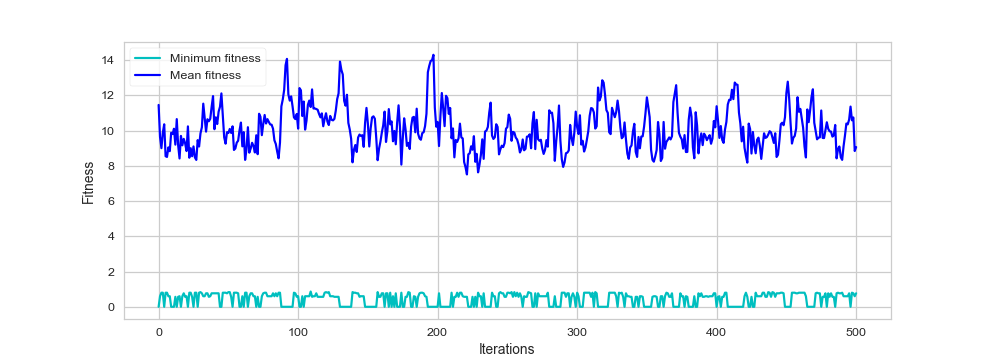

In [27]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');